In [35]:
%matplotlib inline
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import uuid
import os
from joblib import Parallel, delayed
import pickle
import time
import scipy.linalg as splin
from matplotlib import rc
import time
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
import math

In [2]:
def saveThing(thing,file):
    with open(file,'wb') as fil:
        pick = pickle.Pickler(fil)
        pick.dump(thing)
        pick.clear_memo()

def findRow(i,data):
    return [logDist(data[i],data[j]) for j in range(i+1,len(data))]

def openThing(file):
    with open(file,'rb') as fil:
        thing = pickle.load(fil)
    return thing

def projCombine(wi,vi,w,v):
    W = np.concatenate((abs(wi),w))
    V = np.concatenate((vi,v),axis=1)
    sorting = [W.argsort()[-i] for i in range(1,len(W)+1)]
    W = W[sorting]
    V = np.array([point[sorting] for point in V])
    imCol = []
    for i in range(len(W)):
        if W[i] in abs(wi):
            imCol.append(i)
    return(np.sqrt(W)*V,imCol)

def findProjections(DDT,eigs=5):

    wR,vRt = splin.eigh(DDT_PCA,eigvals=(len(DDT_PCA)-1-eigs,len(DDT_PCA)-1))
    wI,vIt = splin.eigh(DDT_PCA,eigvals=(0,eigs))
    
    W = list(wR)
    W.extend(list(wI))
    W = np.array(W)
    sorting = abs(np.array(W)).argsort()[::-1]
    
    V = list(vRt.T)
    V.extend(list(vIt.T))
    V = np.array(V)
    
    W = W[sorting]
    V = V[sorting]
    
    imCol = []
    for i in range(len(W)):
        if W[i] < 0:
            imCol.append(i)
            
    proj = np.dot(V.T,np.diag(np.sqrt(np.abs(W))))
    
    return proj,imCol




def plotProjections(projections, params, colorCoding, imCol = [], emphPoints=[], emphColors='black',reduced = False, cmap='plasma', gridsize=4):
    xsize = 4
    ysize = 4
    figs, axs = plt.subplots(nrows = gridsize, ncols = gridsize, figsize=(4*xsize,4*ysize))
    figs.suptitle('CMB Model Manifold', fontsize=20)
    if reduced:
        CLIST = np.array([params[i][colorCoding]/params[i]['H0']**2 for i in range(len(params))])
    else:
        CLIST = np.array([params[i][colorCoding] for i in range(len(params))])
    for row in range(gridsize):
        for col in range(gridsize):
            if col >= row:
                if col == row:
                    sortIndex = row+2
                else:
                    sortIndex = row+1
                py = projections[:,row]
                px = projections[:,col+1]
                sorting = projections[:,sortIndex].argsort()
                
                clist = CLIST[sorting]
                PX = px[sorting]
                PY = py[sorting]
                
                rangeX = PX.max() - PX.min()
                centerX = (PX.max() + PX.min())/2.0
                rangeY = PY.max() - PY.min()
                centerY = (PY.max() + PY.min())/2.0
                axesDist = 0.6*max(rangeX,rangeY)
                
                sc1 = axs[row,col].scatter(PX,PY,alpha=0.7,c=clist,cmap=cmap,edgecolor='black',linewidth=0.2)
                sc2 = axs[row,col].scatter(px[emphPoints],py[emphPoints],c=emphColors,s=100)
                
                subTitle = " "
                
                if (row in imCol):
                    subTitle += r" imaginary "+str(row + 1)+"   vs.   "
                else:
                    subTitle += r" real "+str(row + 1)+"   vs.   "
                if (col + 1 in imCol):
                    subTitle += r" imaginary " +str(col + 2)
                else:
                    subTitle += r" real " +str(col + 2)
                
                axs[row,col].set_title(subTitle)
                axs[row,col].set_xlim([centerX - axesDist, centerX + axesDist])
                axs[row,col].set_ylim([centerY - axesDist, centerY + axesDist])
                axs[row,col].ticklabel_format(style='sci', scilimits=(-2,2),axis='both')
            else:
                axs[row,col].axis('off')
    cbar_ax = figs.add_axes([0.95,0.15,0.01,0.7])
    cbar_ax.title.set_text(colorCoding)
    figs.colorbar(sc1,cax=cbar_ax,cmap=cmap)
    #plt.tight_layout()
    plt.show()

def loadParams(paramFil,params = ['hubble','ombh2','omch2','re_optical_depth','scalar_spectral_index(1)','scalar_amp(1)']):
    paramList = []
    with open(paramFil,'r') as fil:
        for row in fil:
            paramList.append(row)
    paramList_short = {}
    for param in params:
        for element in paramList:
            if param in element:
                tempVal = float(element.replace('=','').replace('\n','').replace(param,''))
                paramList_short.update({param:tempVal})
                break
    return paramList_short

def loadOldParam(folder):
    with open(folder) as fil:
        params = []
        for row in fil:
            data = row.split(',')
            params.extend([float(data[i]) for i in range(0,6)])
    return params

def loadData(folder,fil):
    data = []
    with open(folder + '/' + fil,'r') as fil:
        for row in fil:
            data.append([float(x) for x in row.split( )])
    return np.array(data)

def loadCl(folder,index):
    return loadData(folder,str(index) + '_scalCls.dat')

def logDist(cl1,cl2):
    imax = min(len(cl1),len(cl2))
    logDist = 0.0
    for i in range(imax):
        l1, cl1TT, cl1EE, cl1TE = cl1[i]
        l2, cl2TT, cl2EE, cl2TE = cl2[i]
        l = l1
        
        a = (((cl1TE+cl2TE)**2 - (cl1EE + cl2EE)*(cl1TT+cl2TT)))**2
        c = (cl1TE**2-cl1TT*cl1EE) * (cl2TE**2-cl2TT*cl2EE)
        d = np.log(16)
        element = (-(2*l+1)/4.0)*(np.log(abs(a)) - np.log(abs(c)) - d)
        logDist += element
    return -logDist

def openRawText(filePath):
    with open(filePath,'r') as fil:
        file = []
        for dat in fil:
            line = dat.split()
            try:
                file.append([float(element) for element in line])
            except ValueError:
                pass
    return np.array(file)

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

planckFit = openRawText('PlanckData/PlanckFit.txt')
planckFit = np.array([[row[0],row[1],row[3],row[4],row[2],0,0] for row in planckFit])

planck_TT_low = openRawText('PlanckData/TT_low.txt')
planck_TT_high = openRawText('PlanckData/TT_high.txt')
planck_TE_low = openRawText('PlanckData/TE_low.txt')
planck_TE_high = openRawText('PlanckData/TE_high.txt')
planck_EE_low = openRawText('PlanckData/EE_low.txt')
planck_EE_high = openRawText('PlanckData/EE_high.txt')
planck_BB = openRawText('PlanckData/BB_low.txt')
planck_TB = openRawText('PlanckData/TB_low.txt')
planck_EB = openRawText('PlanckData/EB_low.txt')

planck_TT = []
for row in planck_TT_low:
    planck_TT.append(row)
for row in planck_TT_high:
    planck_TT.append([row[0],row[1],row[2],row[2]])
planck_TT = np.array(planck_TT)

planck_EE = []
for row in planck_EE_low:
    planck_EE.append(row)
for row in planck_EE_high:
    planck_EE.append([row[0],row[1],row[2],row[2]])
planck_EE = np.array(planck_EE)

planck_TE = []
for row in planck_TE_low:
    planck_TE.append(row)
for row in planck_TE_high:
    planck_TE.append([row[0],row[1],row[2],row[2]])
planck_TE = np.array(planck_TE)

planck = [[row[0],row[1],0,0,0,0,0] for row in planck_TT]
for row_EE in planck_EE:
    for row in planck:
        if row_EE[0] == row[0]:
            row[2] = row_EE[1]
            break
for row_BB in planck_BB:
    for row in planck:
        if row_BB[0] == row[0]:
            row[3] = row_BB[1]
            break
for row_TE in planck_TE:
    for row in planck:
        if row_TE[0] == row[0]:
            row[4] = row_TE[1]
            break
for row_TB in planck_TB:
    for row in planck:
        if row_TB[0] == row[0]:
            row[5] = row_TB[1]
            break
for row_EB in planck_EB:
    for row in planck:
        if row_EB[0] == row[0]:
            row[6] = row_EB[1]
            break
planck = np.array(planck)
planckPos = np.array([[row[0],np.abs(row[1]),max(row[2],0.0),np.abs(row[3]),row[4],row[5],row[6]] for row in planck])

Planck = np.array([[row[0],row[1],row[2],row[4]] for row in planck[0:1000]])

In [400]:
pause = True
while pause:
    allFiles = os.listdir('MC_Planck')
    filMax = 0
    for fil in allFiles:
        try:
            ind = int(fil.replace('_params.ini',''))
            if ind > filMax:
                filMax = ind
        except ValueError:
            pass
    if filMax >= 100:
        pause = False

In [531]:
allFiles = os.listdir('MC_Planck_fixedRanges')
filMax = 0
for fil in allFiles:
    try:
        ind = int(fil.replace('_params.ini',''))
        if ind > filMax:
            filMax = ind
    except ValueError:
        pass
print(filMax)

79047


In [532]:
params = [loadParams('MC_Planck_fixedRanges/universe_params.ini')]
for ind in range(filMax):
    try:
        params.append(loadParams('MC_Planck_fixedRanges/'+str(ind)+'_params.ini'))
    except IOError:
        pass

In [533]:
accept = openThing('MC_Planck_fixedRanges/accept_list.pckl')
print('number of sampled points:',filMax)
print('acceptance rate:         ',float(sum(accept))/len(accept))

('number of sampled points:', 79047)
('acceptance rate:         ', 0.41952867063868543)


In [534]:
clUni = loadCl('MC_Planck_fixedRanges','universe')

In [535]:
dist = [logDist(Planck,clUni)]
for ind in range(filMax):
    try:
        cl = loadCl('MC_Planck_fixedRanges',str(ind))
        dist.append(logDist(Planck,cl))
    except IOError:
        dist.append(None)

('min distance:', nan)
('current fit distance:', 5482.6445342764355)


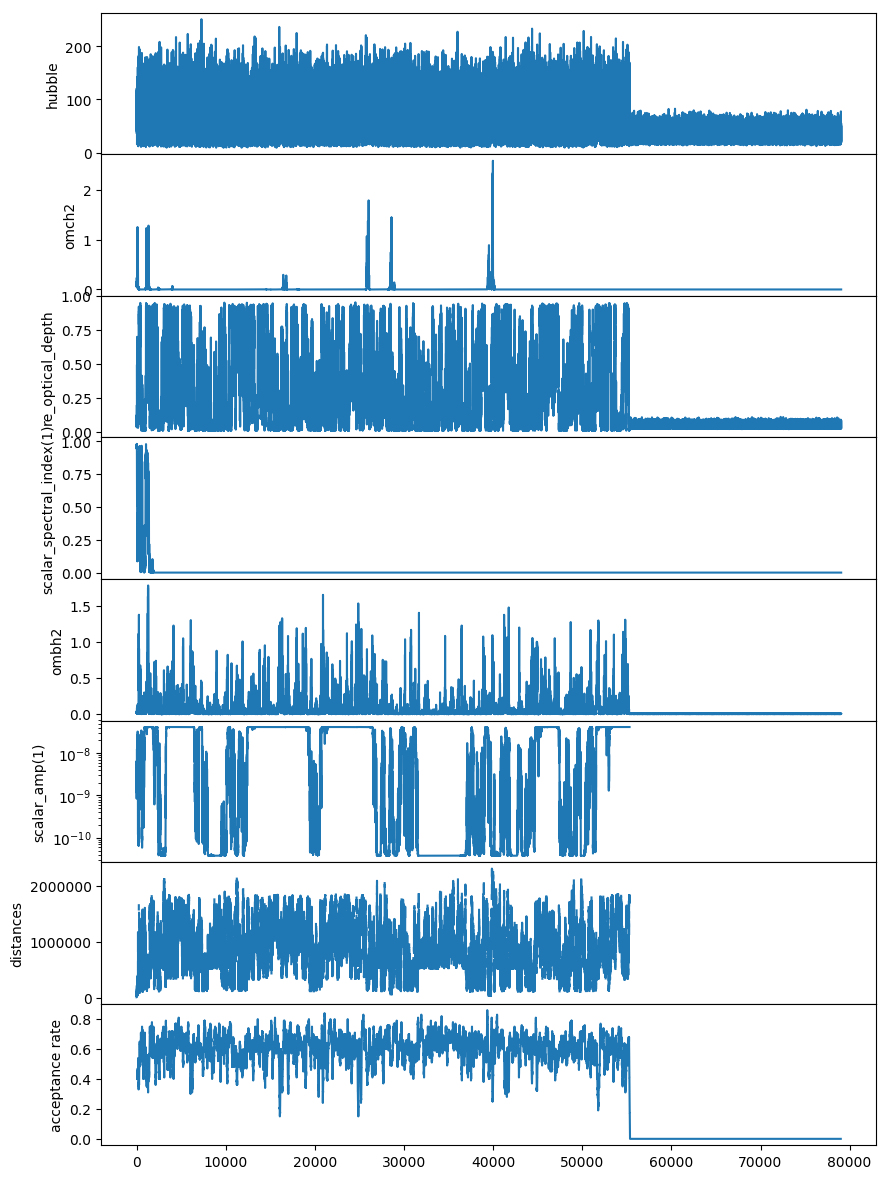

In [536]:
minDist = dist[0]
for d in dist:
    if d != None:
        minDist = min([d,minDist])
print('min distance:',minDist)
print('current fit distance:',dist[0])

fig,axes = plt.subplots(ncols=1,nrows=8,sharex = True,figsize=(10,15))
fig.subplots_adjust(hspace=0)

axes[6].plot(dist)
axes[6].set_ylabel('distances')

axes[7].plot([i for i in range(50,len(accept)-50)],[float(sum(accept[(i-50):i+50]))/100 for i in range(50,len(accept)-50)])
axes[7].set_ylabel('acceptance rate')

idx = 0
for key in params[0]:
    axes[idx].plot([param[key] for param in params])
    axes[idx].set_ylabel(key)
    if key == 'scalar_amp(1)':
        axes[idx].set_yscale('log')
    idx += 1

plt.show()

In [537]:
params[-1]

{'hubble': 22.9552621948,
 'ombh2': 0.00535344110344,
 'omch2': 3.92070848249e-27,
 're_optical_depth': 0.0747429866245,
 'scalar_amp(1)': nan,
 'scalar_spectral_index(1)': 6.93066504436e-39}

In [538]:
clist = []
slist = []
for x in dist:
    if x == None:
        slist.append(0)
        clist.append(-1)
    else:
        slist.append(2)
        clist.append(x)

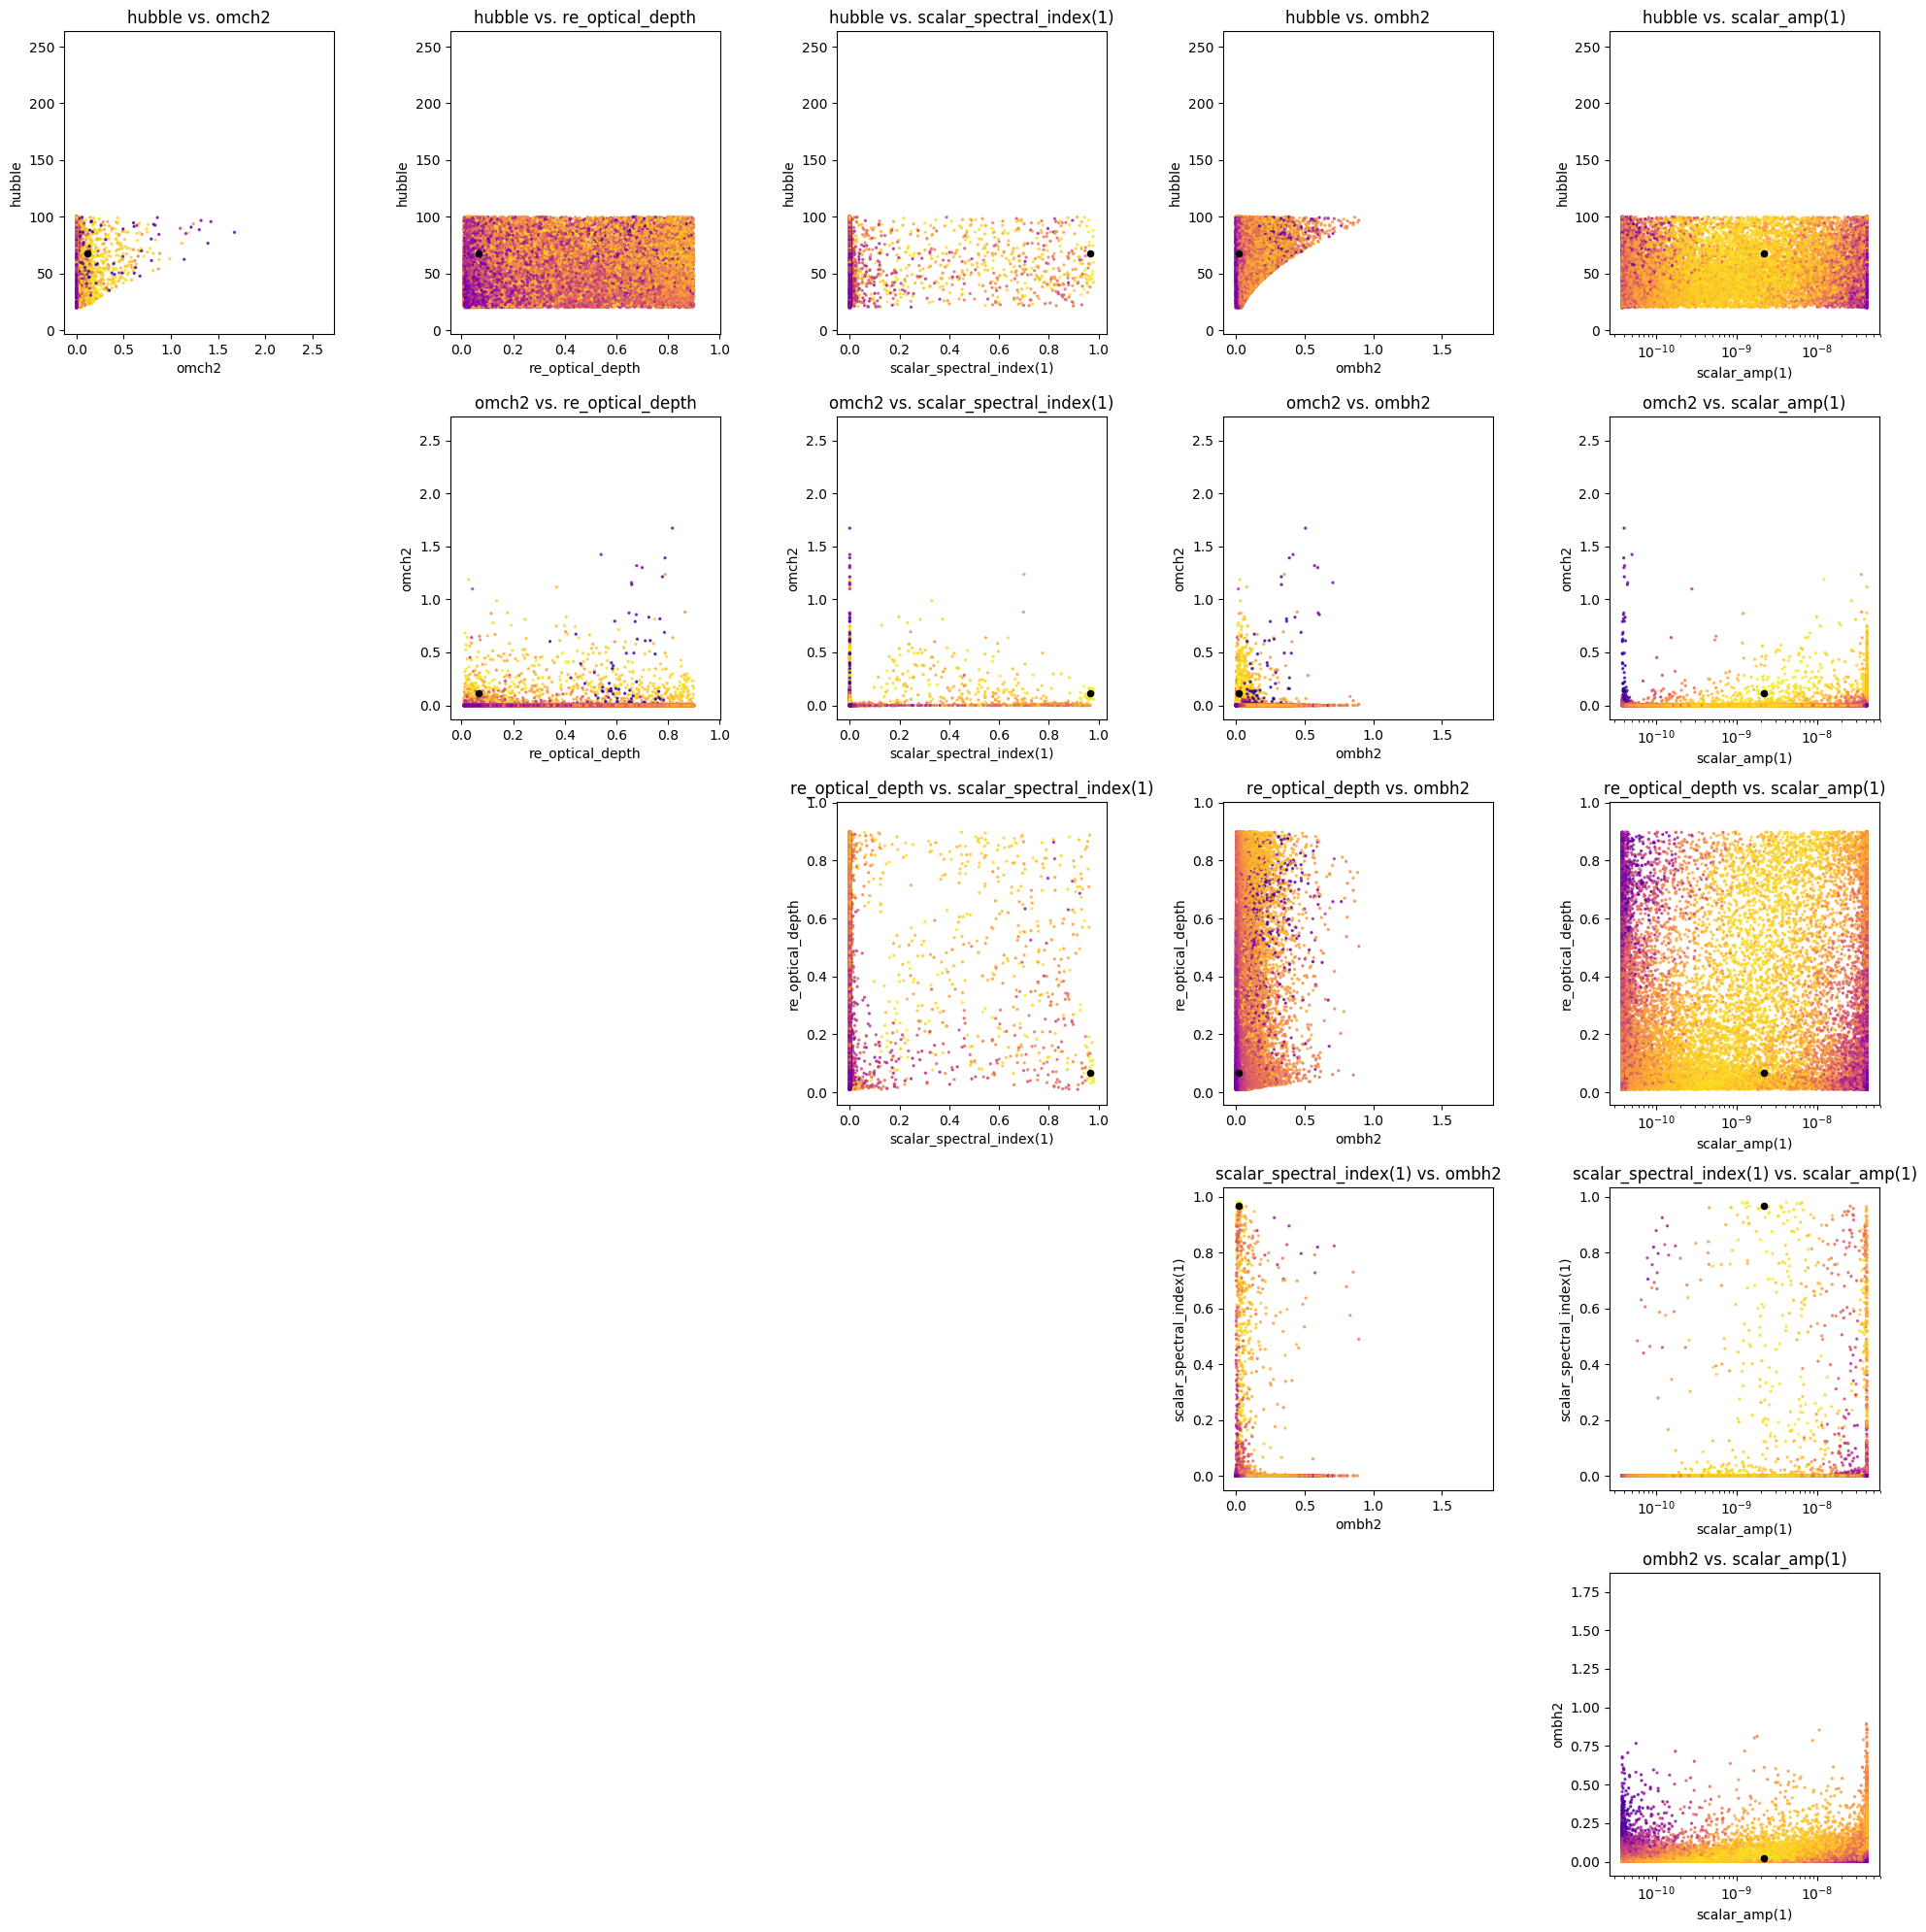

In [539]:
keys = [key for key in params[0]]
gSize = len(keys)-1
fig,axes = plt.subplots(nrows=gSize,ncols=gSize,figsize=(4*gSize,4*gSize))
for row in range(gSize):
    for col in range(gSize):
        if col >= row:
            py = [param[keys[row]] for param in params]
            px = [param[keys[col+1]] for param in params]
            
            if keys[row] == 'scalar_amp(1)':
                axes[row,col].set_yscale('log')
            if keys[col+1] == 'scalar_amp(1)':
                axes[row,col].set_xscale('log')
            
            img = axes[row,col].scatter(px,py,alpha=0.7,c=-np.array(clist),s=slist,cmap='plasma')
            img2 = axes[row,col].scatter([px[0]],[py[0]],c='black',s=20)
            
            subTitle = keys[row] + ' vs. ' + keys[col+1]
            
            axes[row,col].set_title(subTitle)
            axes[row,col].set_xlabel(keys[col+1])
            axes[row,col].set_ylabel(keys[row])
            #axes[row,col].ticklabel_format(style='sci',scilimits=(-2,2),axis='both')
        else:
            axes[row,col].axis('off')
plt.tight_layout()
plt.show()

In [554]:
Data = [Planck,loadCl('MC_Planck_fixedRanges','universe')]
Params = [loadParams('MC_Planck_fixedRanges/universe_params.ini'),loadParams('MC_Planck_expProb/universe_params.ini')]
for i in range(0,50000,5):
    try:
        Data.append(loadCl('MC_Planck_fixedRanges',str(i)))
        Params.append(loadParams('MC_Planck_fixedRanges/'+str(i)+'_params.ini'))
    except IOError:
        pass
print(len(Data))

6469


In [555]:
distances = Parallel(n_jobs=14)(delayed(findRow)(i,Data) for i in range(len(Data)))

In [556]:
DDT = [[0.0 for d0 in Data] for d1 in Data]
for i in range(len(Data)):
    for j in range(i+1,len(Data)):
        DDT[i][j] = -distances[i][j-(i+1)]
        DDT[j][i] = DDT[i][j]
        
DDT_sums = [sum(row)/len(DDT) for row in DDT]
DDT_sum_sums = sum(DDT_sums)/len(DDT)

DDT_PCA = [[DDT[i][j] - DDT_sums[i] - DDT_sums[j] + DDT_sum_sums for i in range(len(Data))] for j in range(len(Data))]

In [557]:
eigNumb = 5
#wi,vi = splin.eigh(DDT_PCA,eigvals=(0,eigNumb))
#w,v = splin.eigh(DDT_PCA,eigvals=(len(DDT_PCA)-eigNumb-1,len(DDT_PCA)-1))

proj,imCol = findProjections(DDT_PCA)

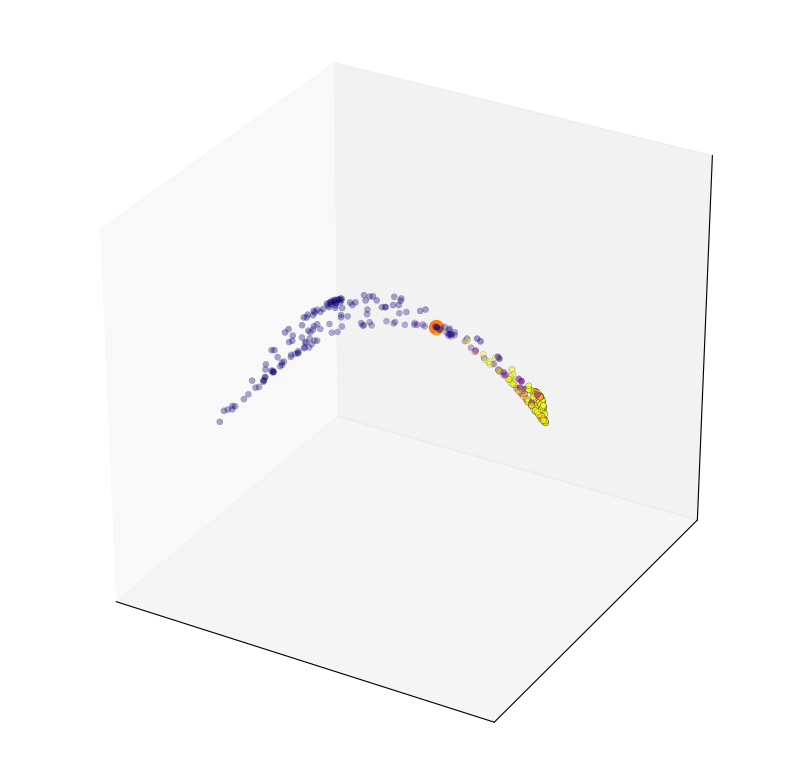

In [552]:
#3D plots
px = proj[:,0]
py = -proj[:,1]
pz = proj[:,2]

mean_x = px.min()
mean_y = py.min()
mean_z = pz.min()

Xdist = px.max() - px.min()
Xcntr = (px.max() + px.min())/2.0
Ydist = py.max() - py.min()
Ycntr = (py.max() + py.min())/2.0
Zdist = pz.max() - pz.min()
Zcntr = (pz.max() + pz.min())/2.0

dist = 0.6*max(Xdist,Ydist,Zdist)

fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
#ax.view_init(30,-60)

listTemp = [i for i in range(len(proj))]

ax.scatter(px,py,pz,c=[param['scalar_amp(1)'] for param in Params],edgecolor='black',linewidth=0.2,cmap = 'plasma')
ax.scatter([px[0]],[py[0]],[pz[0]],c='C1',s=100)

"""img = ax.scatter(px,py,[Zcntr - dist for p in proj],alpha=0.05,c='C0')
ax.scatter(px,[Ycntr + dist for p in proj],pz,alpha=0.05,c='C0')
ax.scatter([Xcntr - dist for p in proj],py,pz,alpha=0.05,c='C0')"""

ax.set_xlim([Xcntr - dist, Xcntr + dist])
ax.set_ylim([Ycntr - dist, Ycntr + dist])
ax.set_zlim([Zcntr - dist, Zcntr + dist])

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

arrowSize=2*dist/5

#ax.set_axis_off()

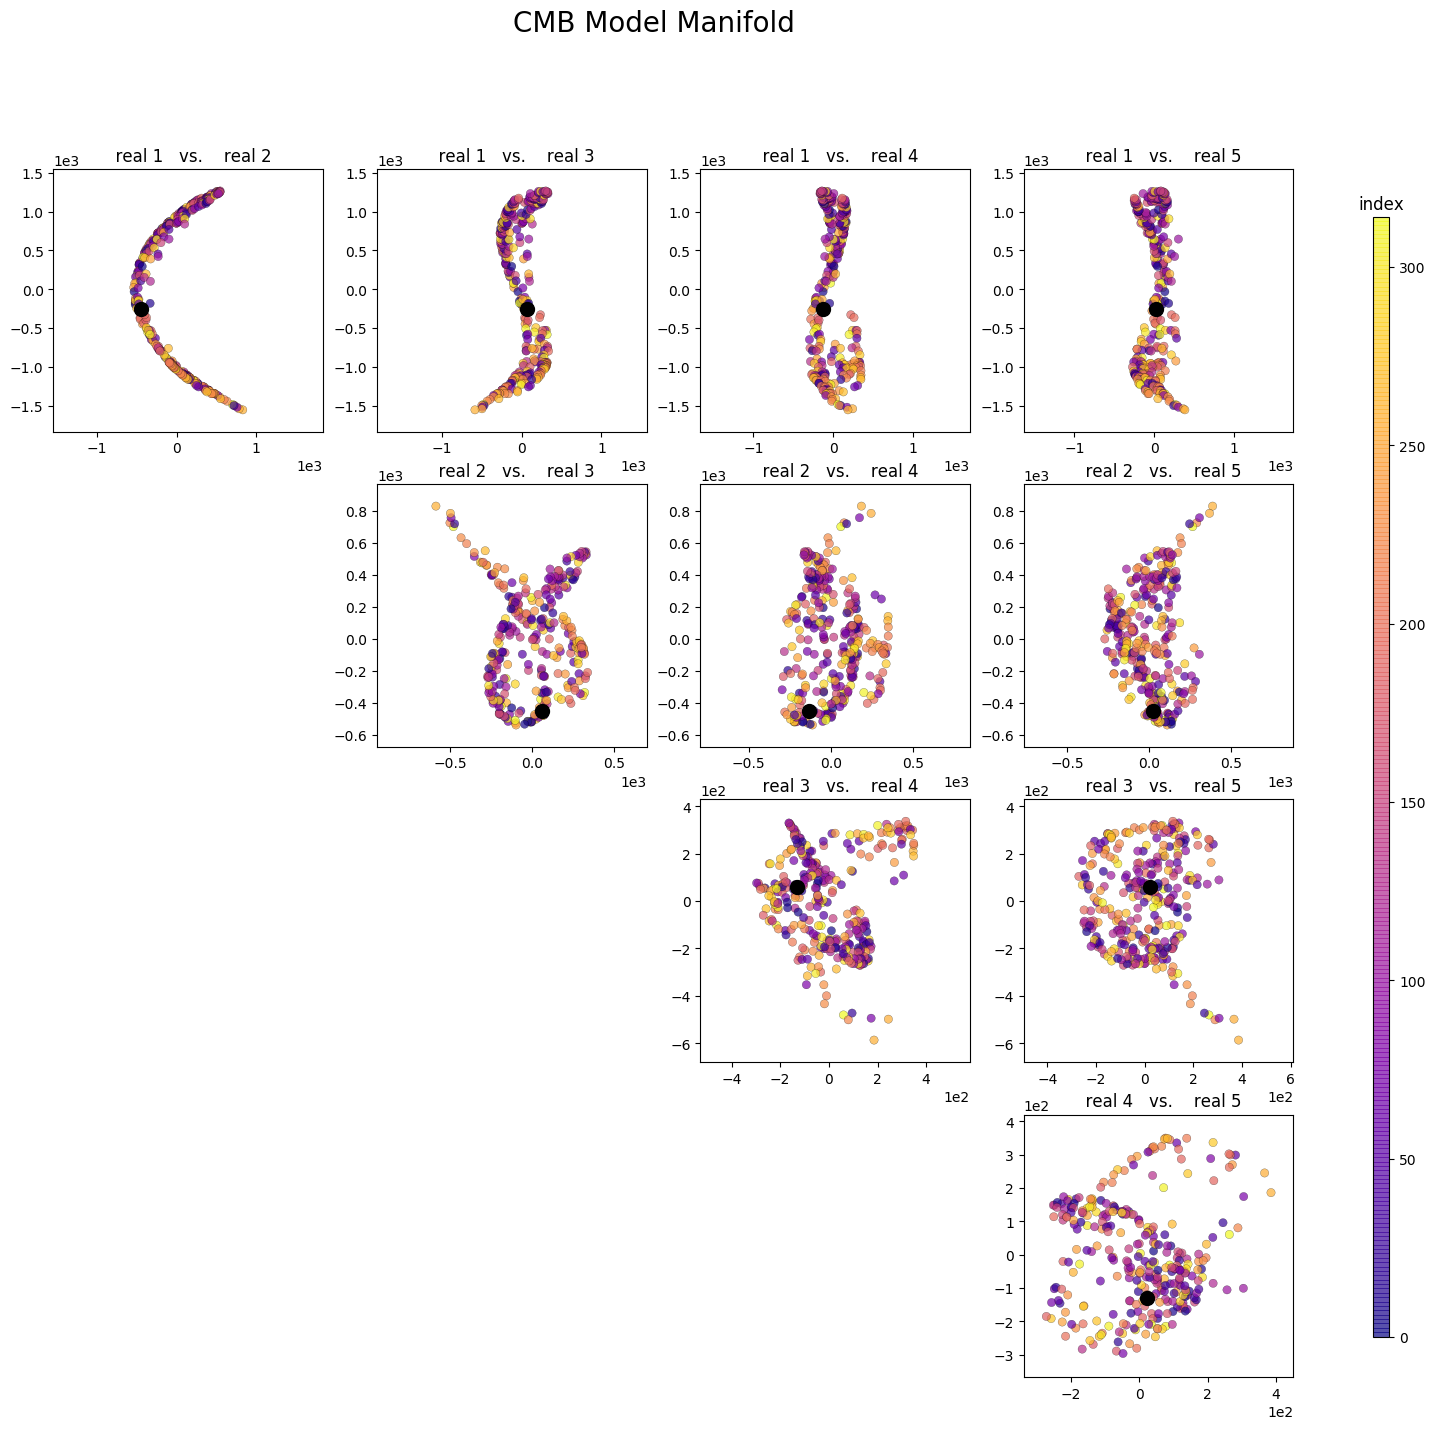

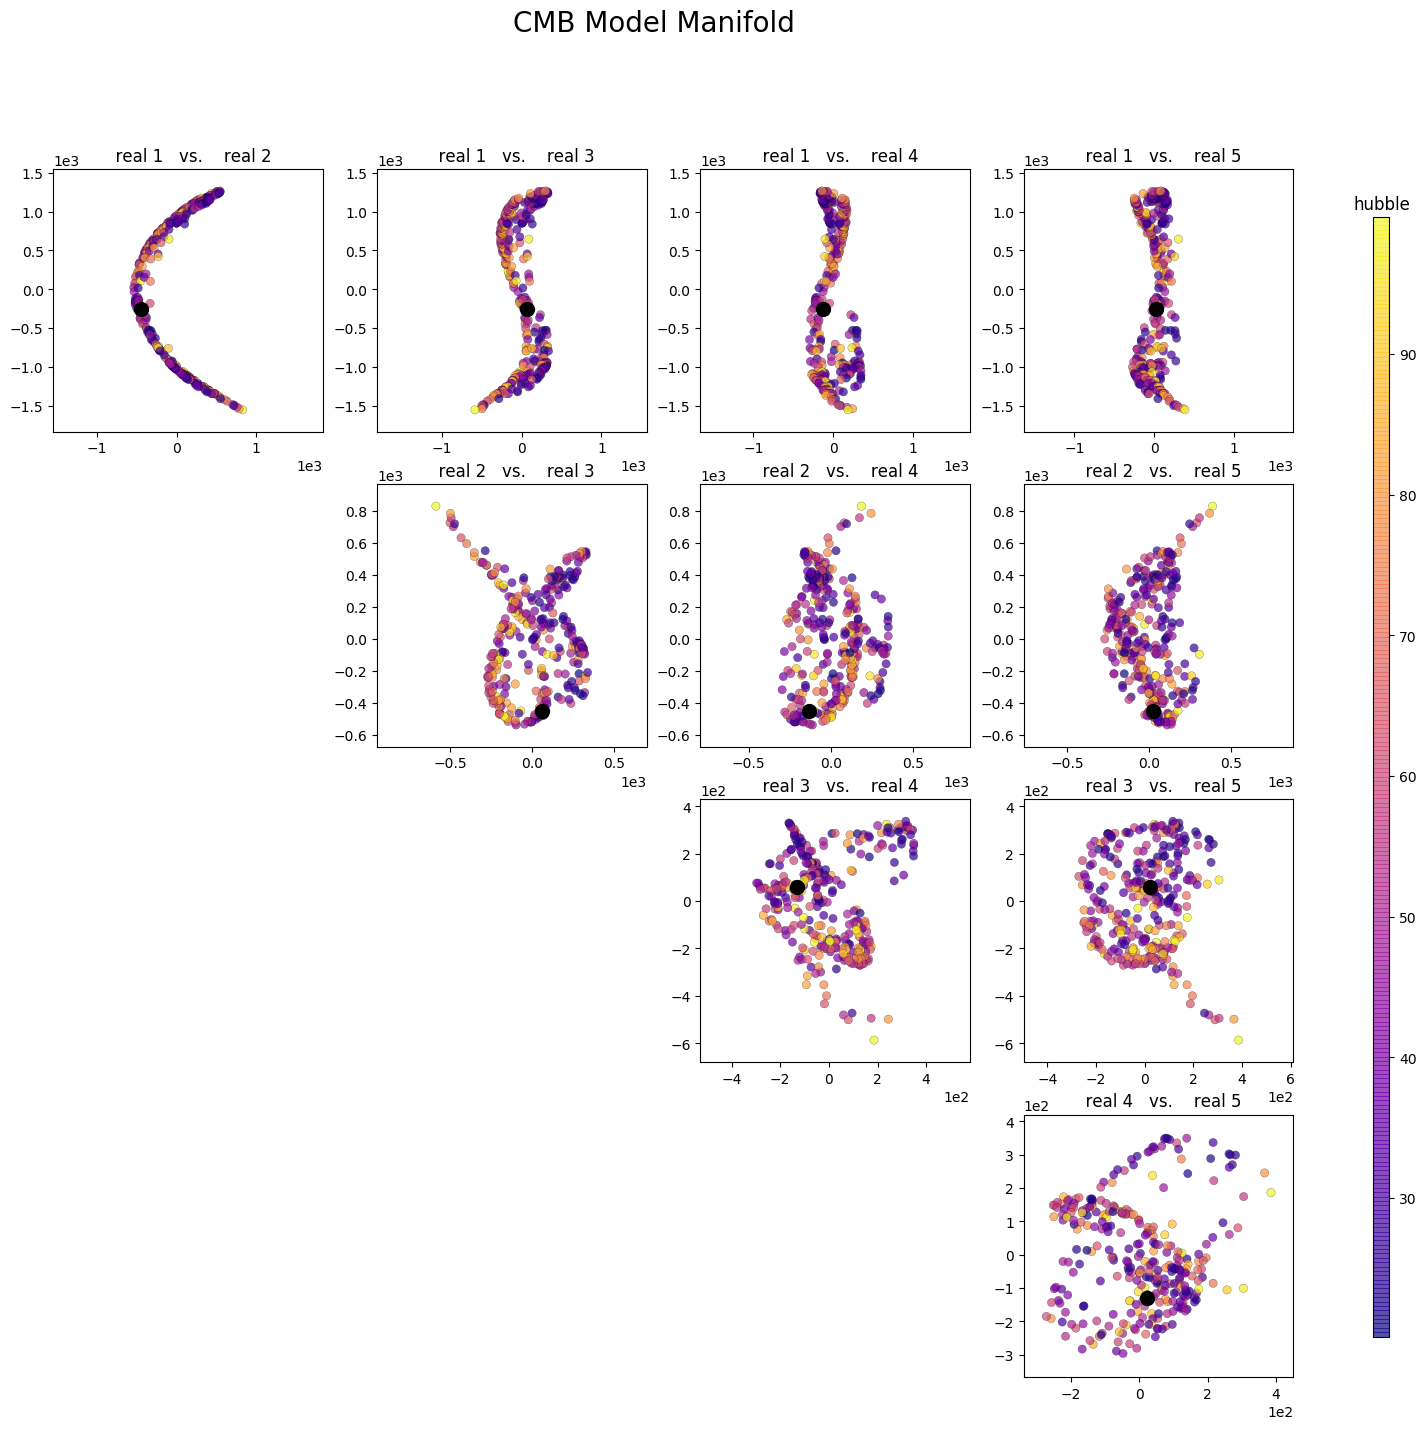

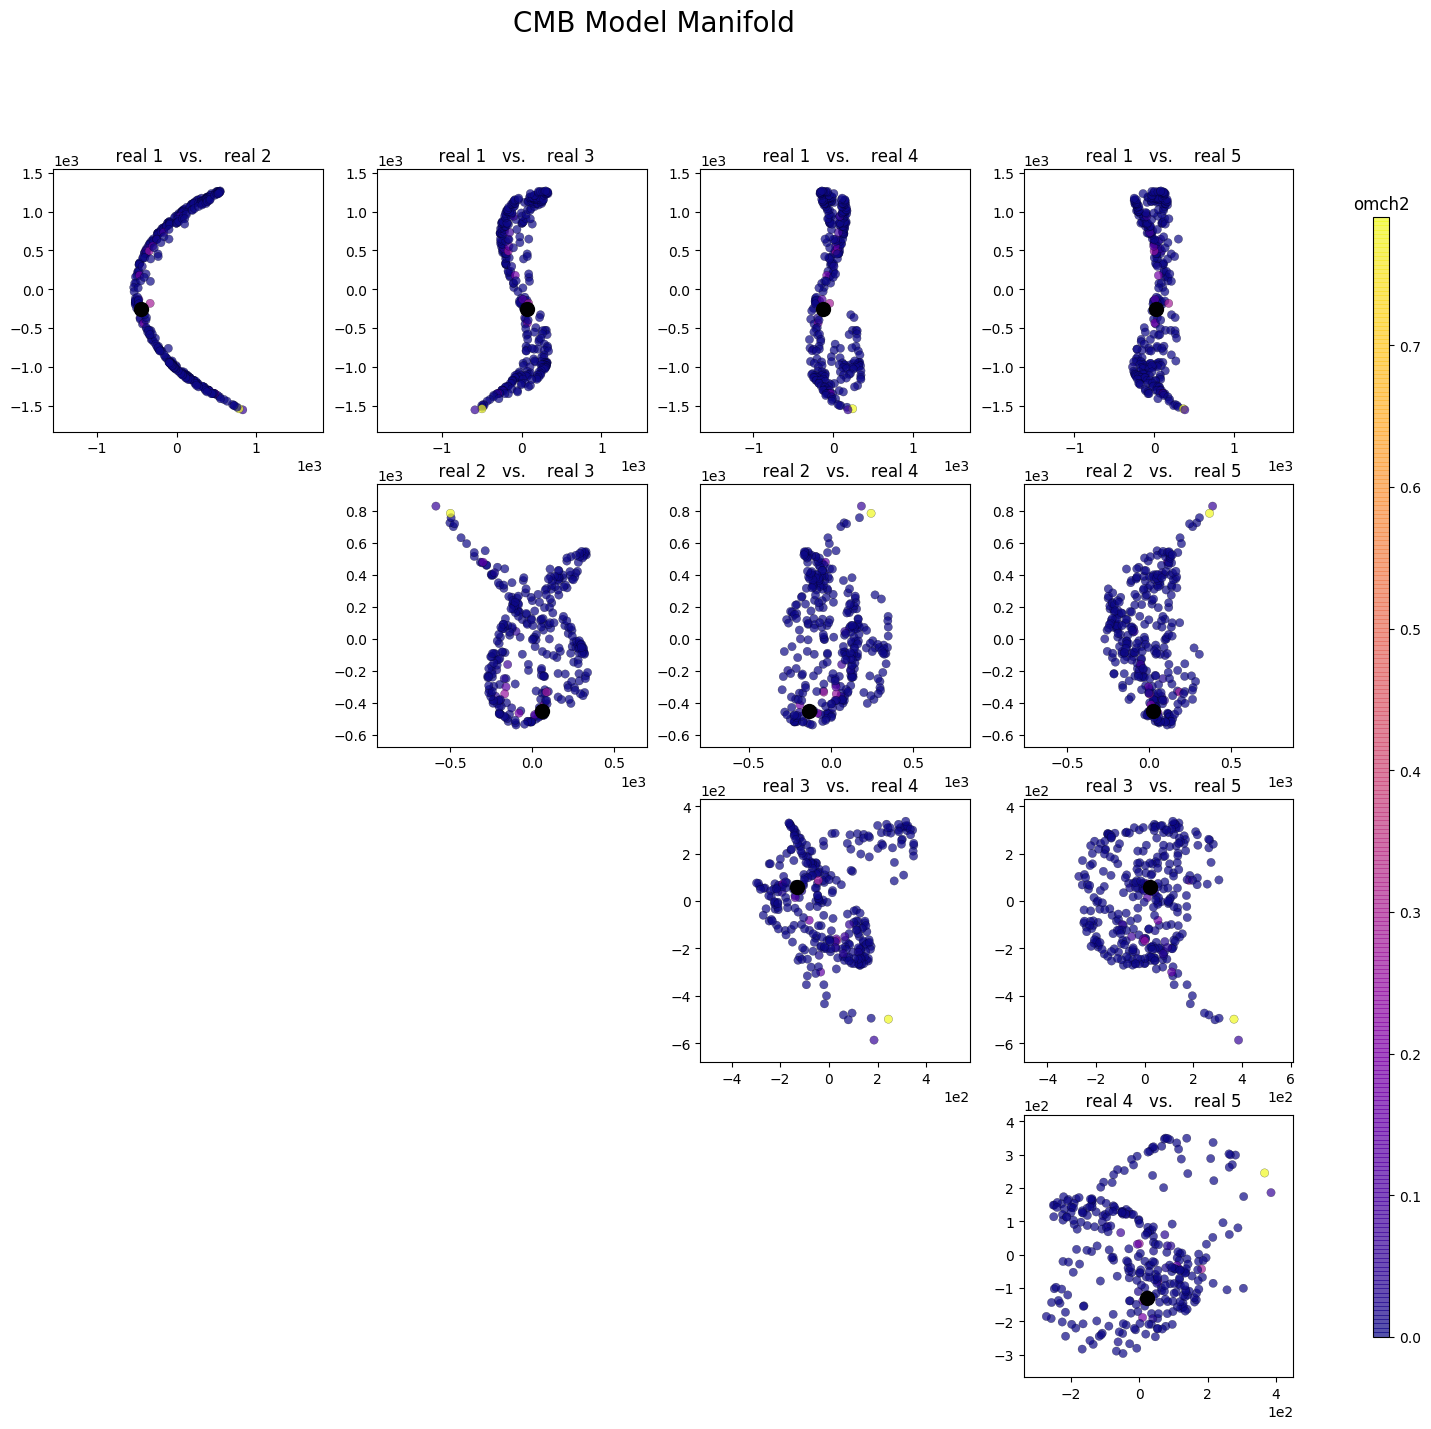

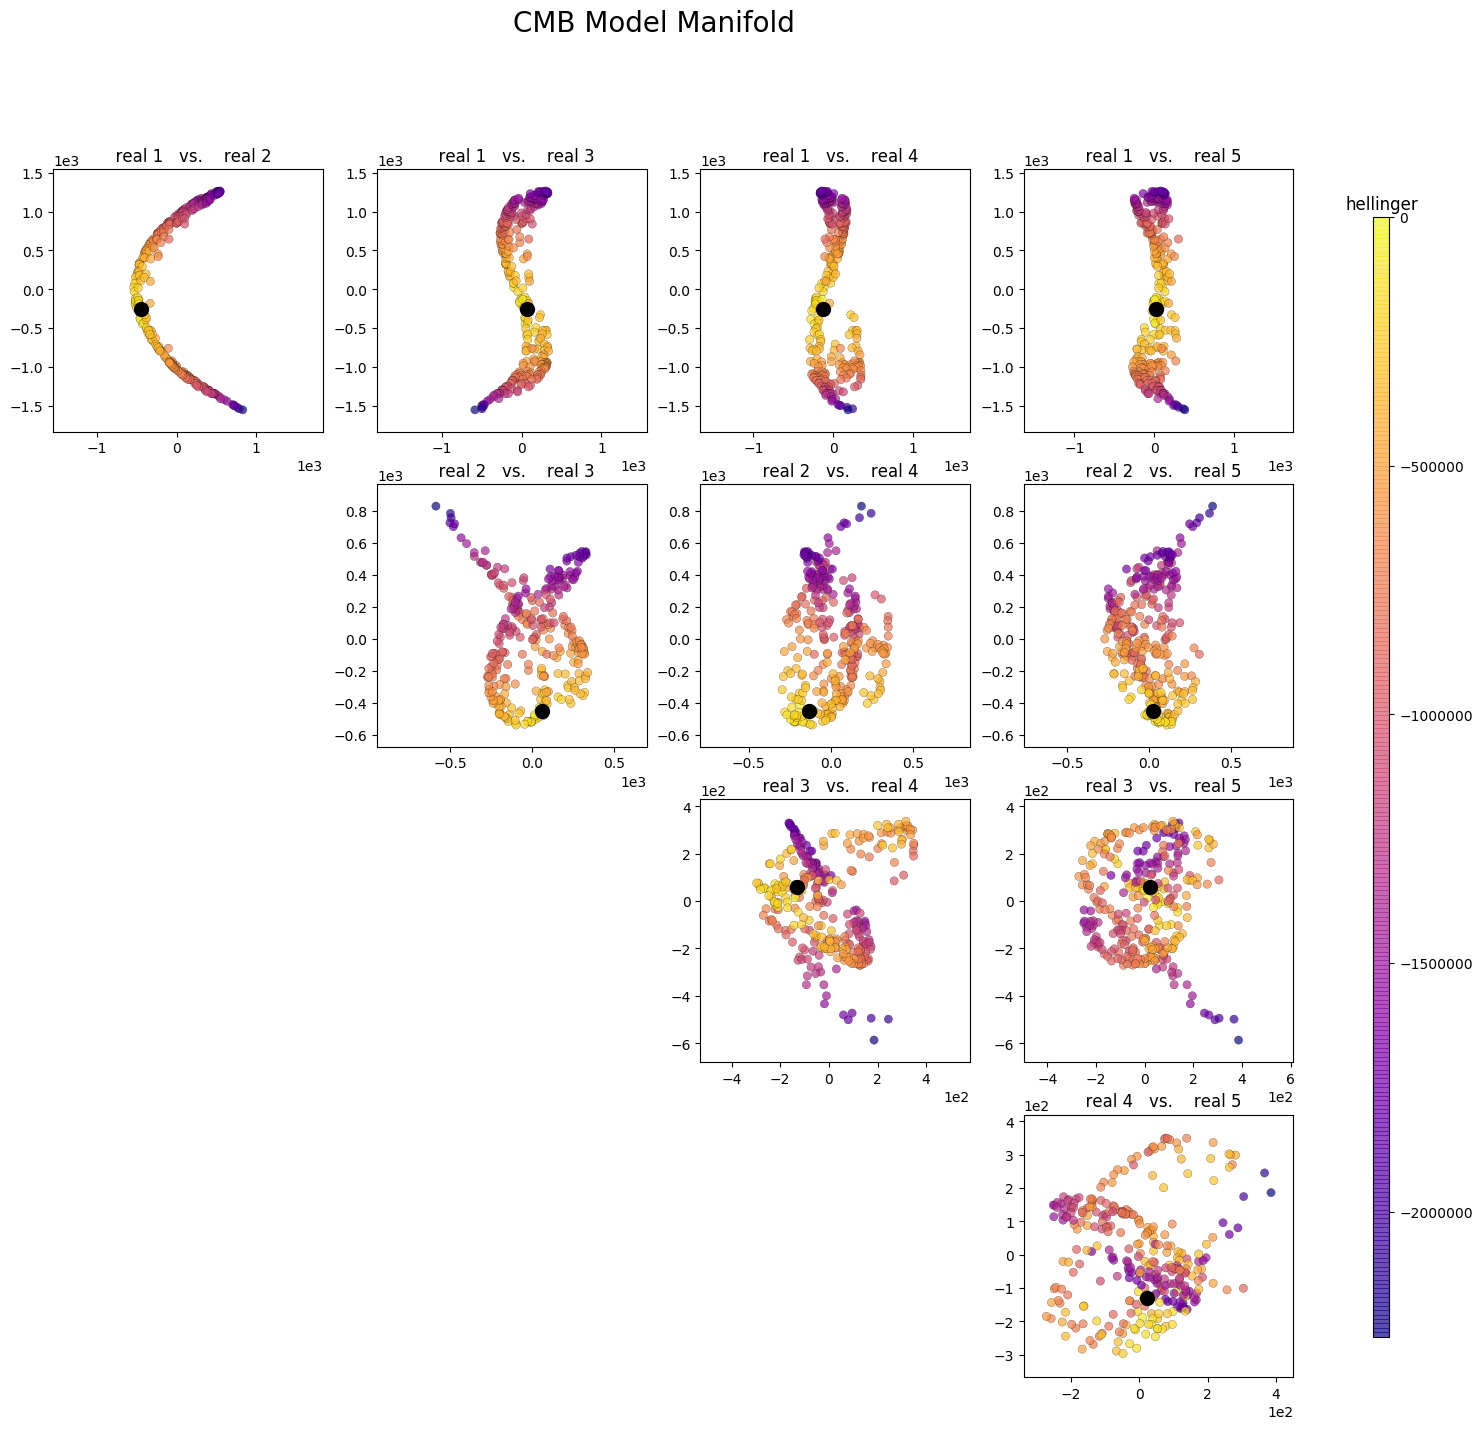

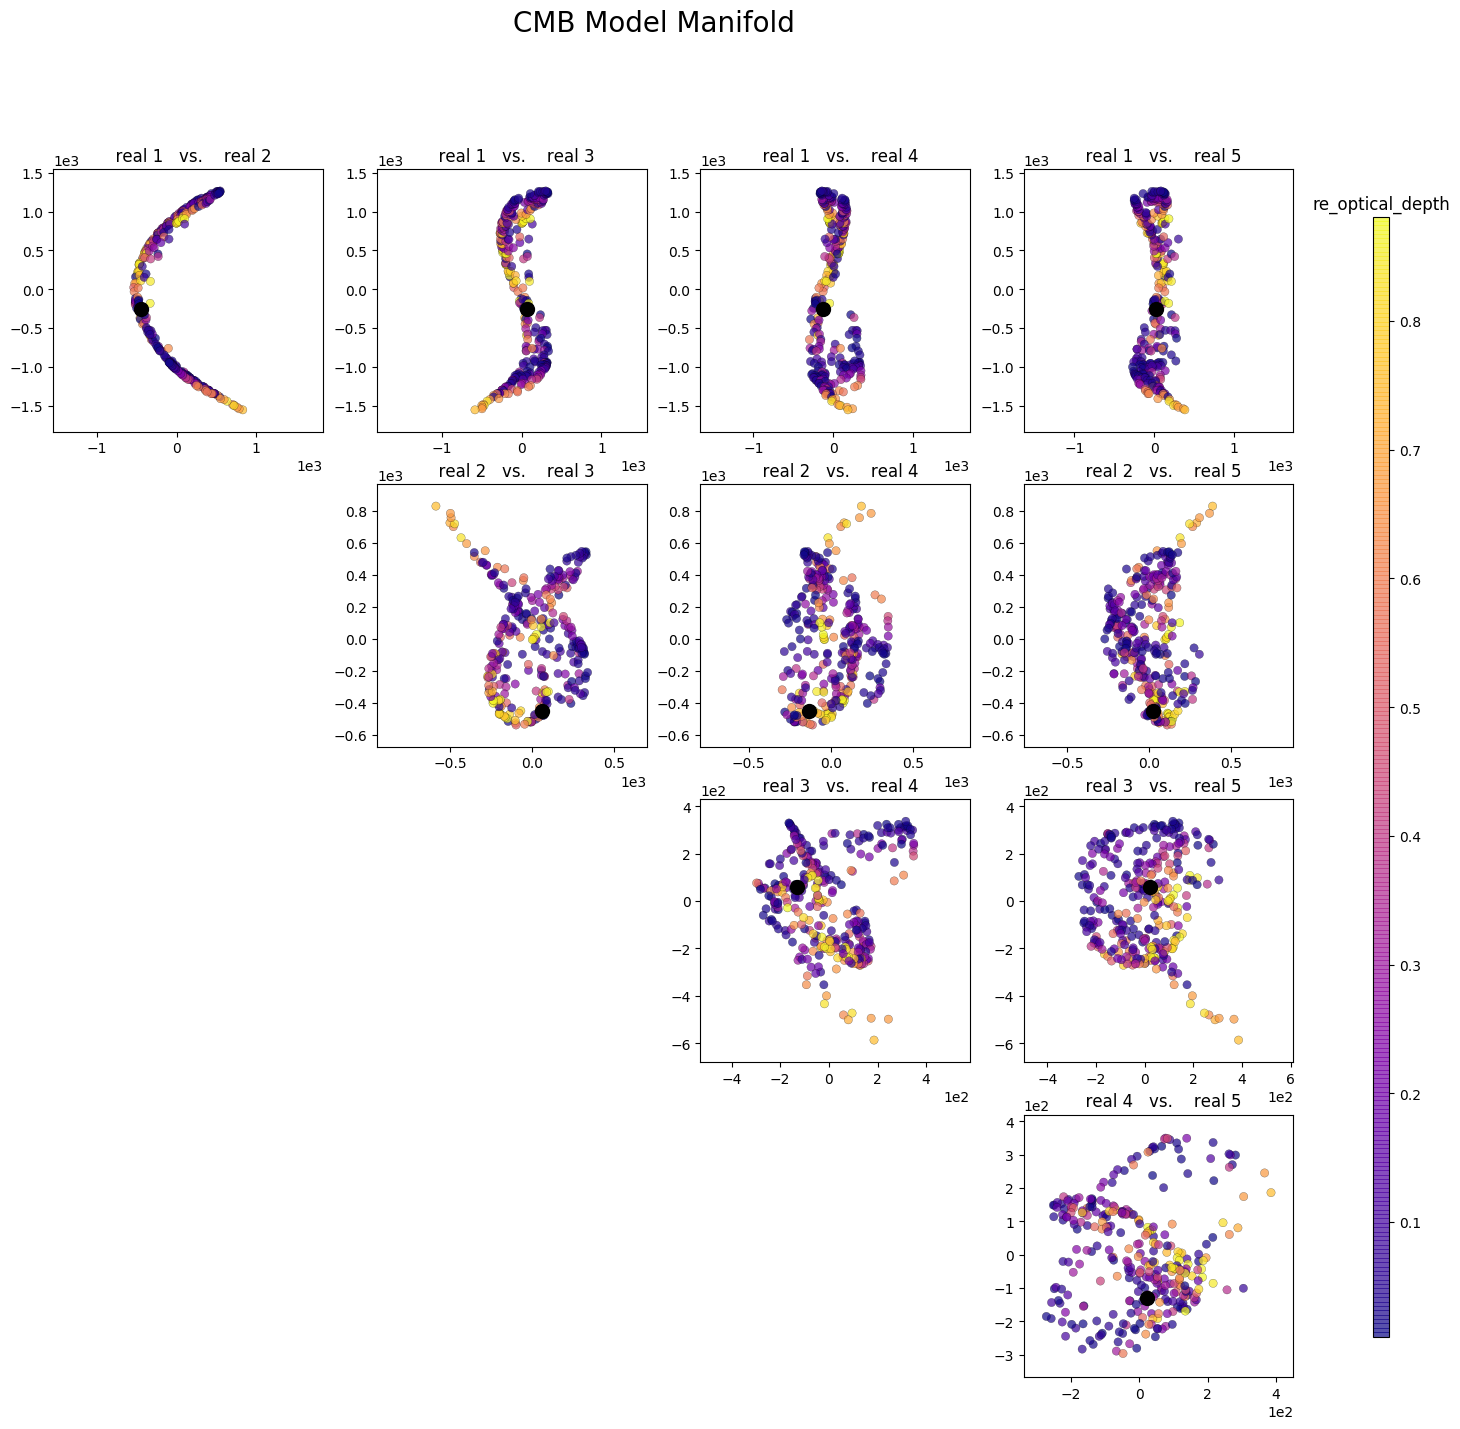

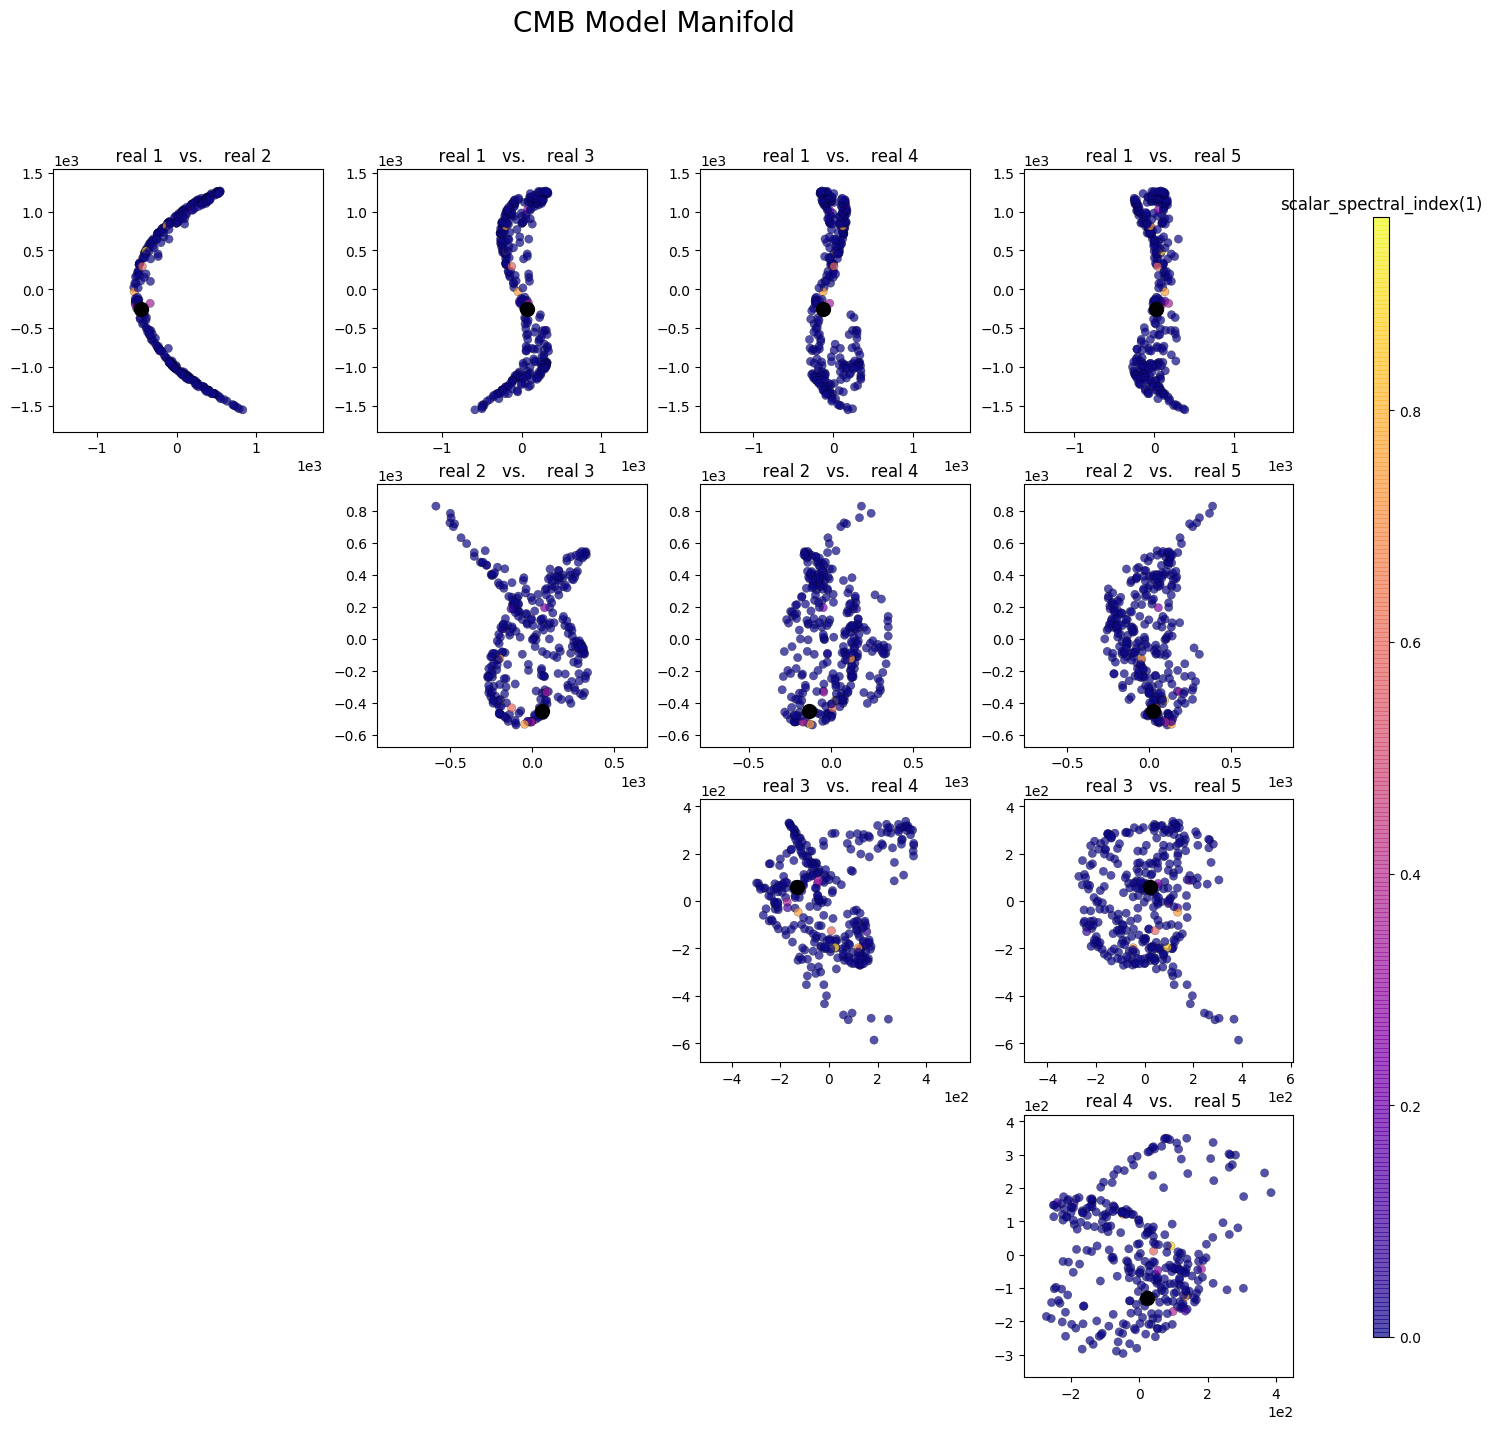

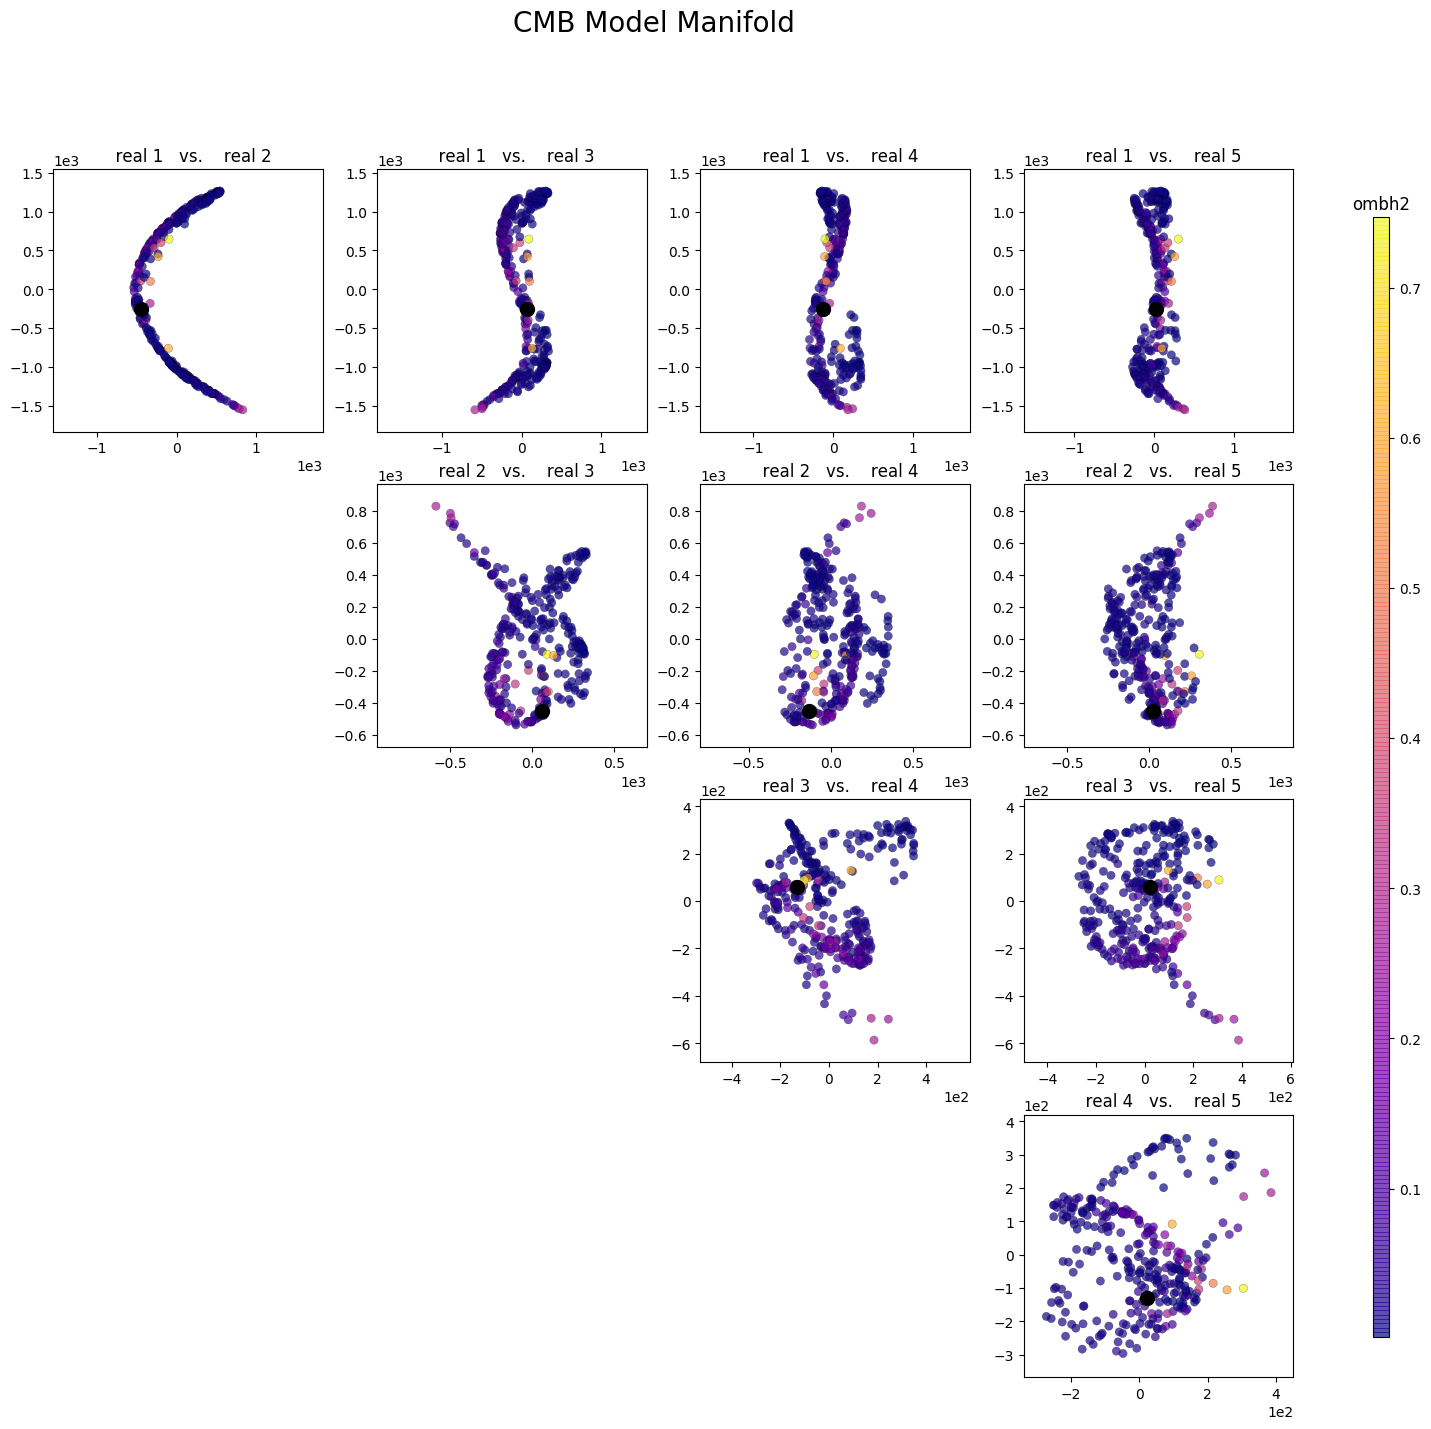

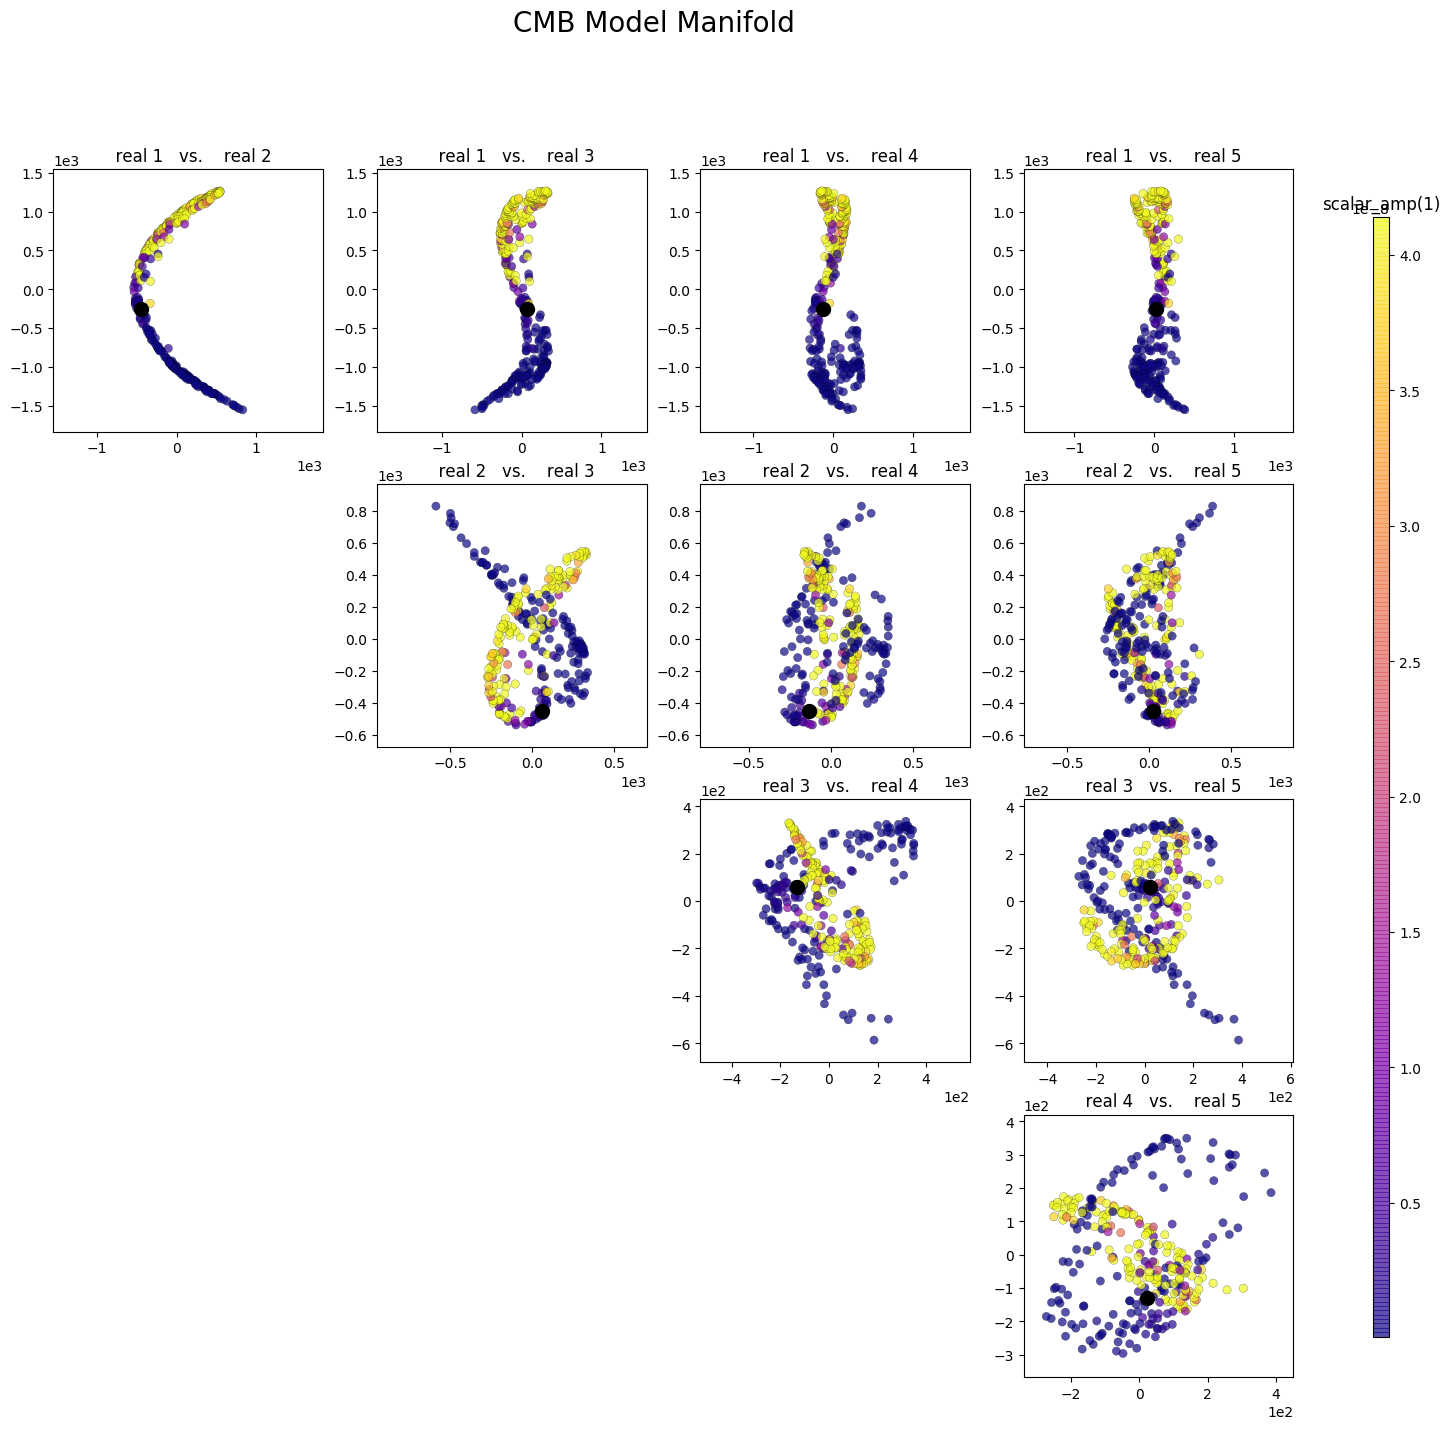

In [549]:
for i in range(len(Params)):
    Params[i].update({'hellinger':DDT[0][i],'index':i})
for key in Params[0]:
    plotProjections(proj,Params,key,imCol=imCol,emphPoints=[0])

In [527]:
maxCutoff = 1500
minCutoff = -1000

clMax = []
paramsMax = []

clMin = []
paramsMin = []

for i in range(len(Data)):
    if proj[i][0] > maxCutoff:
        clMax.append(Data[i])
        paramsMax.append(Params[i])
    if proj[i][0] < minCutoff:
        clMin.append(Data[i])
        paramsMin.append(Data[i])
print(len(clMax))
print(len(clMin))

0
0


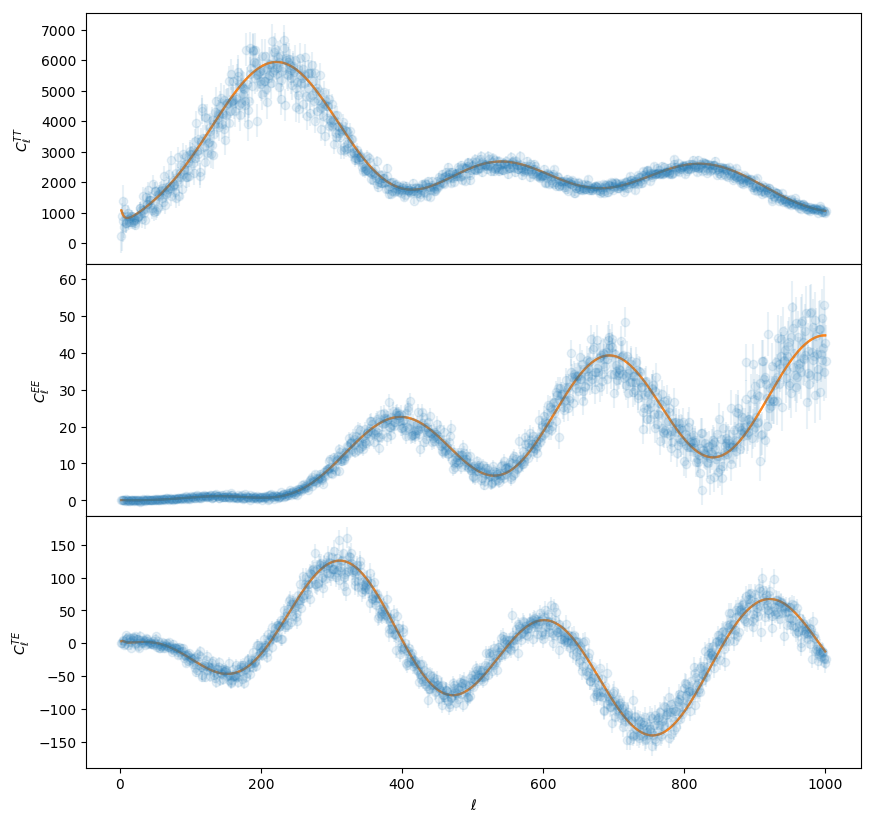

In [528]:
for clSet in [Data[1:5],Data[-5:-1]]:
    fig,axes = plt.subplots(ncols=1,nrows=3,sharex = True,figsize=(10,10))
    emphC = 'C0'
    
    dataSet = planck_TT[0:1000]
    axes[0].errorbar(dataSet[:,0],dataSet[:,1],yerr=[dataSet[:,2],dataSet[:,3]],fmt='o',alpha=0.1,c=emphC)
    axes[0].plot(clUni[:,0],clUni[:,1],c=emphC,alpha=0.1)
    axes[0].set_ylabel(r'$C_\ell^{TT}$')
    
    dataSet = planck_EE[0:1000]
    axes[1].errorbar(dataSet[:,0],dataSet[:,1],yerr=[dataSet[:,2],dataSet[:,3]],fmt='o',alpha=0.1,c=emphC)
    axes[1].plot(clUni[:,0],clUni[:,2],c=emphC,alpha=0.005)
    axes[1].set_ylabel(r'$C_\ell^{EE}$')

    
    dataSet = planck_TE[0:1000]
    axes[2].errorbar(dataSet[:,0],dataSet[:,1],yerr=[dataSet[:,2],dataSet[:,3]],fmt='o',alpha=0.1,c=emphC)
    axes[2].plot(clUni[:,0],clUni[:,3],c=emphC,alpha=0.005)
    axes[2].set_xlabel(r'$\ell$')
    axes[2].set_ylabel(r'$C_\ell^{TE}$')
    
    
    for cl in clSet:
        axes[0].plot(cl[:,0],cl[:,1],c='C1',alpha=0.5)
        axes[1].plot(cl[:,0],cl[:,2],c='C1',alpha=0.5)
        axes[2].plot(cl[:,0],cl[:,3],c='C1',alpha=0.5)
        
    fig.subplots_adjust(hspace=0)
    plt.show()

In [529]:
fig,axes = plt.subplots(ncols=1,nrows=3,sharex = True,figsize=(10,10))
emphC = 'C0'

axes[0].set_ylabel(r'$C_\ell^{TT}$')
axes[1].set_ylabel(r'$C_\ell^{EE}$')
axes[2].set_xlabel(r'$\ell$')
axes[2].set_ylabel(r'$C_\ell^{TE}$')


for cl in [Data[1],Data[-1]]:
    axes[0].plot(cl[:,0],cl[:,1],alpha=0.5)
    axes[1].plot(cl[:,0],cl[:,2],alpha=0.5)
    axes[2].plot(cl[:,0],cl[:,3],alpha=0.5)

fig.subplots_adjust(hspace=0)
plt.show()

In [558]:
saveThing(distances,'MC_Planck_fixedRanges_data/distances.pckl')
saveThing(Planck,'MC_Planck_fixedRanges_data/PlanckCl.pckl')
saveThing(planck_TT,'MC_Planck_fixedRanges_data/planck_TT.pckl')
saveThing(planck_EE,'MC_Planck_fixedRanges_data/planck_EE.pckl')
saveThing(planck_TE,'MC_Planck_fixedRanges_data/planck_TE.pckl')
saveThing(proj,'MC_Planck_fixedRanges_data/proj.pckl')
saveThing(imCol,'MC_Planck_fixedRanges_data/imCol.pckl')
saveThing(Data,'MC_Planck_fixedRanges_data/Data.pckl')
saveThing(Params,'MC_Planck_fixedRanges_data/Params.pckl')
saveThing(DDT,'MC_Planck_fixedRanges_data/DDT.pckl')